In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, 'models')
sys.path.insert(0, 'utils')
sys.path.insert(1, '../dsvae/yukun_disentanglement_lib/')
import tensorflow_hub as hub
import tensorflow as tf
import yukun_disentanglement_lib
import celeba
import numpy as np
import wandb
import matplotlib.pyplot as plt
import numpy as np
import torch
import argparse
from plotting_utils import plot_pytorch_images
from misc import merge

from dsvae_model import DSVAE, loss_function
from datasets import DSVAE_DATA

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--num_datapoints", help="num datapoints", default=100000, type=int)
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=1, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--start_epoch", help="epoch to start training from (requires checkpoints)", default=0, type=int)
parser.add_argument("--save_interval", help="epochs to save model", default=10, type=int)
parser.add_argument("--run_seed", help="run seed of TCVAE", default=100, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--batch_size", help="batch size", default=100, type=int)
args = parser.parse_args([])

num_datapoints=args.num_datapoints

log = False
if log:
    wandb.init(project="pytorch_dsvae", name="celeba_{}".format(num_datapoints))
    wandb.config.update(args)

device = args.device
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))
print("start_epoch: {}".format(args.start_epoch))
print("save_interval: {}".format(args.save_interval))
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[args.device], 'GPU')

z_dim: 85
GPU: 1
start_epoch: 0
save_interval: 10


# Preparing Data

In [3]:
load = True
save = True
num_y_samples = 10
tf.set_random_seed(1)
classifier_url = '../dsvae/tcvae_models/celeba/train_output/100k/d_15_b_15_{}/tfhub/'.format(100)
num_samples=num_datapoints
if not load:
    dta = celeba.CelebA(celeba_path="../dsvae/yukun_disentanglement_lib/img_align_celeba", num_samples=num_samples)
    ys = np.float32(np.empty((num_samples, num_y_samples, 64, 64,3)))
    with hub.eval_function_for_module(classifier_url) as f:
        for j in range(num_y_samples):
            y = []
            for i in range(10):
                x = np.float32(dta.images[i*int(num_samples/10):(i+1)*int(num_samples/10)])
                y.append(f(dict(images=x), signature="reconstructions", as_dict=True)["images"]) 
            ys[:,j] = np.float32(np.concatenate(y,axis=0))
    inputs = np.float32(dta.images)
    targets = np.float32(ys)
    del dta
    if save:
        np.save('saved_data/inputs_{}_sample'.format(num_samples), inputs)
        np.save('saved_data/targets_{}_sample'.format(num_samples), targets)     
else:  
    inputs = np.load('saved_data/inputs_{}_sample.npy'.format(num_samples))
    targets = np.load('saved_data/targets_{}_sample.npy'.format(num_samples))
    
torch_inputs = torch.from_numpy(inputs).permute(0,3,1,2)
torch_targets = torch.from_numpy(targets).permute(0,1,4,2,3)
torch_dataset = DSVAE_DATA(torch_inputs, torch_targets)
torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=True)

# Instantiating and Training DSVAE

In [4]:
if device != -1 and device is not None:
    dsvae = DSVAE(z_dim=85, y_shape=[3,64,64], input_shape=[3,64,64], device=args.device)
    dsvae.to(device)
else:
    dsvae = DSVAE(z_dim=85, y_shape=[3,64,64], input_shape=[3,64,64], device=None)
optimizer = torch.optim.Adam(params=dsvae.parameters(), lr=args.lr)

Training for 1500 epochs...


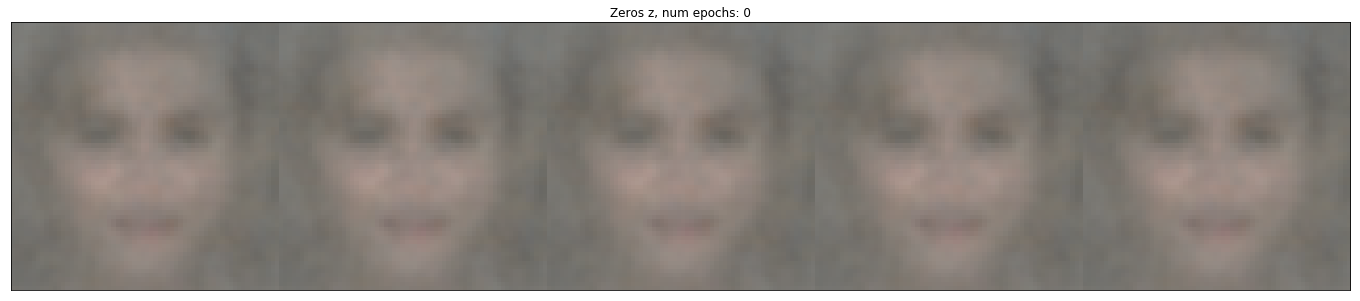

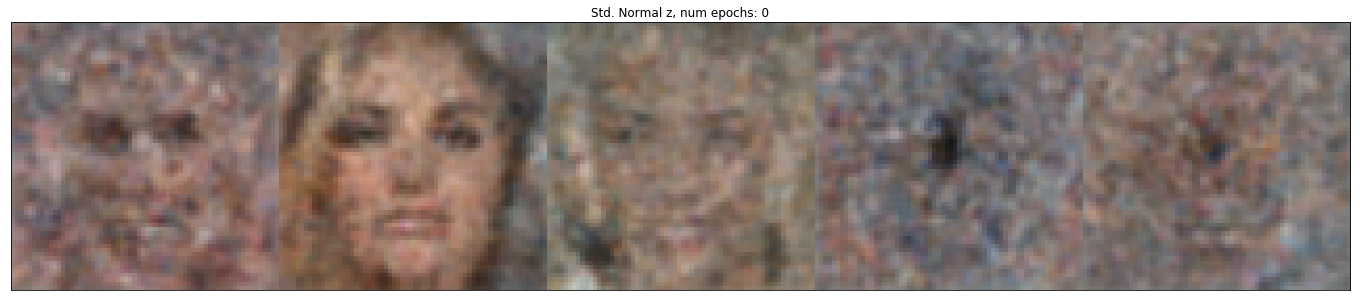

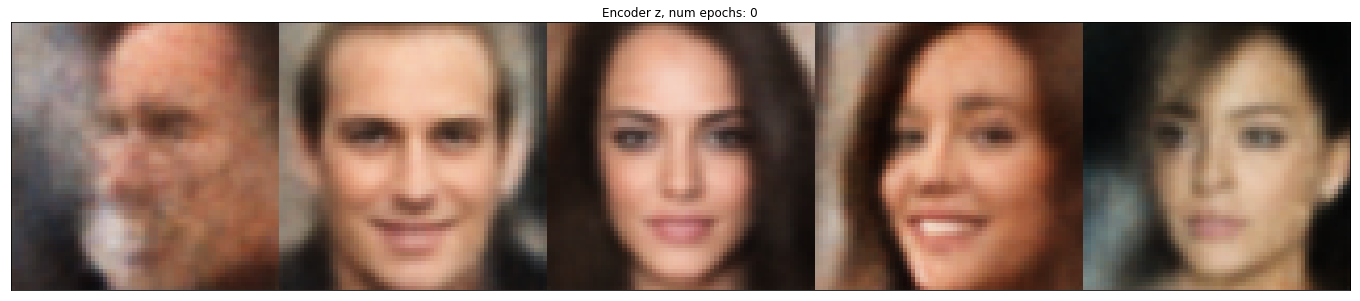

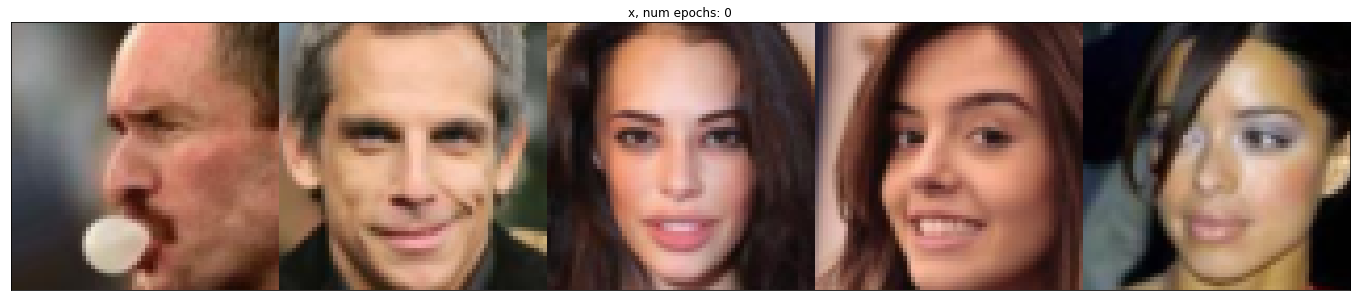

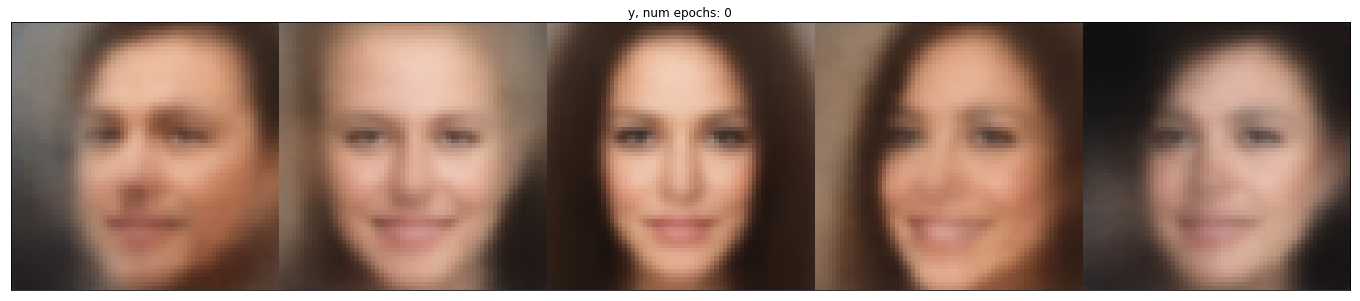

E0326 17:17:15.140517 140334557873920 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/root/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-960d67ac5277>", line 22, in <module>
    optimizer.step()
  File "/root/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/torch/optim/adam.py", line 95, in step
    exp_avg.mul_(beta1).add_(1 - beta1, grad)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/envs/tensorflow_gpu/lib/python3.7/s


KeyboardInterrupt



In [10]:
dsvae.train()
normal = torch.distributions.Normal(0,1)
print("Training for {} epochs...".format(1500))
for n in range(0, 1500):
    for (i, X) in enumerate(torch_data_loader):
        x = X[0]
        y_all = X[1]
        rand_int = np.random.randint(0,num_y_samples)
        y = y_all[:,rand_int]
        if dsvae.cuda:
            x = x.to(device)
            y = y.to(device)
        optimizer.zero_grad()
        y = torch.sigmoid(y)
        x_hat, z_mu, z_var = dsvae(x, y)
        loss, recon_loss, kl_loss = loss_function(x_hat, x, z_mu, z_var)
        if log:
            wandb.log({'loss':loss})
            wandb.log({'recon_loss':recon_loss})
            wandb.log({'kl_loss':kl_loss})
        loss.backward()
        optimizer.step()

    if n%20 ==0:
        dsvae.eval() #evaluate model
        z_noise = normal.sample((x.shape[0],85))
        z_zeros = torch.zeros((x.shape[0],85))
        if dsvae.cuda:
            z_noise = z_noise.to(device)
            z_zeros = z_zeros.to(device)
        x_hat_noise = dsvae.decode(z_noise, y)
        x_hat_zeros = dsvae.decode(z_zeros, y)
        
        fig = plot_pytorch_images(x_hat_zeros[:5], num_images=5, title='Zeros z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Zeros z':fig})
            
        fig = plot_pytorch_images(x_hat_noise[:5], num_images=5, title='Std. Normal z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Std. Normal z':fig})
            
        fig = plot_pytorch_images(x_hat[:5], num_images=5, title='Encoder z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Encoder z':fig})
            
        fig = plot_pytorch_images(x[:5], num_images=5, title='x, num epochs: {}'.format(n))
        if log:
            wandb.log({'x':fig})

        fig = plot_pytorch_images(y[:5], num_images=5, title='y, num epochs: {}'.format(n))
        if log:
            wandb.log({'y':fig})   
        dsvae.train() #back to training model

# Peforming Traversals

In [ ]:
load_model=False
if load_model:
    dsvae = torch.load("dsvae_model_100k_more")
dsvae = dsvae.cpu()
dsvae.device = None

In [ ]:
classifier_url = '../dsvae/tcvae_models/celeba/train_output/100k/d_15_b_15_{}/tfhub/'.format(100)
classifier = hub.Module(classifier_url)
dta = celeba.CelebA(celeba_path="../dsvae/yukun_disentanglement_lib/img_align_celeba", num_samples=10000)

In [ ]:
import numbers
import os
from yukun_disentanglement_lib.data.ground_truth import named_data
from yukun_disentanglement_lib.utils import results
from yukun_disentanglement_lib.visualize import visualize_util
from yukun_disentanglement_lib.visualize.visualize_irs import vis_all_interventional_effects
import numpy as np
from scipy import stats
from six.moves import range
from tensorflow import gfile
import gin.tf
from yukun_disentanglement_lib.visualize.visualize_model import latent_traversal_1d_multi_dim, sigmoid, tanh, latent_traversal_1d_multi_dim_dsvae

output_dir = 'visualize_output_sample'
print(output_dir)
overwrite=True
num_animations=15
num_frames=32
fps=10
num_points_irs=10000
# Create the output directory if necessary.
if tf.gfile.IsDirectory(output_dir):
    if overwrite:
        tf.gfile.DeleteRecursively(output_dir)
    else:
        raise ValueError("Directory already exists and overwrite is False.")

gin_config_file = os.path.join(model_dir, "results", "gin", "train.gin")
print(gin_config_file)
gin_dict = results.gin_dict(gin_config_file)

num_pics = 32
module_path = os.path.join(model_dir, "tfhub")
dsvae.eval()
with hub.eval_function_for_module(classifier_url) as f:
    # Save reconstructions.
    random_state = np.random.RandomState(2)
    real_pics = dta.sample_observations(num_pics, random_state)
    raw_pics = f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]
    pics = sigmoid(raw_pics)

    torch_real_pics = torch.from_numpy(real_pics).permute(0,3,1,2).float()
    torch_raw_pics = torch.from_numpy(raw_pics).permute(0,3,1,2).float()
    
    x_hat, _,_ = dsvae(torch_real_pics, torch_raw_pics)
    x_hat_numpy = x_hat.detach().permute(0,2,3,1).numpy()

    paired_pics = np.concatenate((real_pics, pics), axis=2)
    paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
    results_dir = os.path.join(output_dir, "reconstructions")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(
        paired_pics, os.path.join(results_dir, "reconstructions.jpg"))
    paired_pics = np.concatenate((real_pics, pics, x_hat_numpy), axis=2)
    paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
    results_dir = os.path.join(output_dir, "reconstructions")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(
        paired_pics, os.path.join(results_dir, "reconstructions_dsvae.jpg"))
    print("finished reconstructions")
    
    # Save samples
    def _decoder(latent_vectors):
        return f(
          dict(latent_vectors=latent_vectors),
          signature="decoder",
          as_dict=True)["images"]
    num_latent = int(gin_dict["encoder.num_latent"])
    num_pics = 64
    random_codes = random_state.normal(0, 1, [num_pics, num_latent])
    pics = sigmoid(_decoder(random_codes))
    results_dir = os.path.join(output_dir, "sampled")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(pics,
                                    os.path.join(results_dir, "samples.jpg"))
    print("finished samples")
    
    # Save latent traversals.
    input_images = dta.sample_observations(num_pics, random_state)
    result = f(dict(images=input_images), signature="gaussian_encoder", as_dict=True)
    means = result["mean"]
    logvars = result["logvar"]
    raw_pics = _decoder(means)
    torch_real_pics = torch.from_numpy(input_images).permute(0,3,1,2)
    torch_raw_pics = torch.from_numpy(raw_pics).permute(0,3,1,2)
    x_hat, z_mu, z_var = dsvae(torch_real_pics, torch_raw_pics)
    results_dir = os.path.join(output_dir, "traversals")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    for i in range(10):
        dsvae_pics = latent_traversal_1d_multi_dim_dsvae(dsvae, z_mu[i, :], _decoder, means[i, :])
        pics = sigmoid(latent_traversal_1d_multi_dim(_decoder, means[i, :], None)) 
        
        file_name = os.path.join(results_dir, "traversals{}.jpg".format(i))
        visualize_util.grid_save_images([pics], file_name)
        
        file_name = os.path.join(results_dir, "traversals_dsvae{}.jpg".format(i))
        visualize_util.grid_save_images([dsvae_pics], file_name)
    print("finished traversals")
        
    # Save the latent traversal animations.
    results_dir = os.path.join(output_dir, "animated_traversals")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    # Save latent traversal animations as a grid
    results_dir_grid = os.path.join(output_dir, "traversals_grid")
    if not gfile.IsDirectory(results_dir_grid):
        gfile.MakeDirs(results_dir_grid)
    # Cycle through quantiles of a standard Gaussian.
    for i, base_code in enumerate(means[:num_animations]):
        images = []
        y_traversal_images = []
        #print(base_code.shape) #base_code shape is (8, )
        for j in range(base_code.shape[0]):
            code = np.repeat(np.expand_dims(base_code, 0), num_frames, axis=0) #Repeat c for num_frames
            code[:, j] = visualize_util.cycle_gaussian(base_code[j], num_frames) #Get traversal values for 1 dim
            y_traversal = _decoder(code) #y_traversal[0] corresponds to the orginal image
            images.append(np.array(sigmoid(_decoder(code))))
            
            torch_base_x = torch.from_numpy(input_images[i]).float().unsqueeze(0).permute(0,3,1,2)
            torch_base_y = torch.from_numpy(y_traversal[0]).float().unsqueeze(0).permute(0,3,1,2)
            torch_y_traversal = torch.from_numpy(y_traversal).permute(0,3,1,2).float()
            
            x_hat, z_mu, z_var = dsvae(torch_base_x, torch_base_y)
            z_mu_repeat = z_mu.repeat((len(y_traversal),1))
            x_hat_traversal = dsvae.decode(z_mu_repeat, torch_y_traversal)
            x_hat_traversal = x_hat_traversal.detach().permute(0,2,3,1).numpy()
            y_traversal_images.append(x_hat_traversal)
            
            inds = np.arange(0, 32, 4)
            num_images = len(inds)
            y_xbar = np.concatenate((images[j][inds], y_traversal_images[j][inds]))
            img = merge(y_xbar, [2, num_images])
            plt.figure(figsize=(16,16))
            plt.imshow(img)
            plt.gray()
            plt.axis('off')
            plt.savefig(os.path.join(results_dir_grid, "std_gaussian_cycle_latent_%d_sample_%d.jpg" % (j, i)))
            plt.show()
        filename = os.path.join(results_dir, "std_gaussian_cycle%d.gif" % i)
        visualize_util.save_animation(np.array(images), filename, fps)
        filename = os.path.join(results_dir, "twovae_zmean_repeat_std_gaussian_cycle%d.gif" % i)
        visualize_util.save_animation(y_traversal_images, filename, fps)